# 1. Introduction

# 2. Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns
import random

import re
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"DEVICE: {device}")

DEVICE: cuda


# 3. Utils

## 3.1. Common

In [ ]:
def show_sample(image, label):
    
    # convert to numpy array and remove channel dimension if it exists
    img_display = image.squeeze().numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img_display, cmap='gray')
    plt.title(f"Label: {label}", fontsize=12)
    plt.axis('off')
    plt.show()
    
    return label

def evaluate_model(model, test_loader, device, name):
    """
    Performs a final evaluation on the unseen test dataset.
    Prints the accuracy and average loss in English.
    """
    model.eval() # Essential: sets the model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # Disables gradient calculation for efficiency
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate cross entropy loss for the batch
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # Get the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\n[FINAL EVALUATION: {name}]")
    print(f"Test Samples: {len(test_loader.dataset)}")
    print(f"Average Loss: {avg_test_loss:.4f}")
    print(f"Accuracy:     {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    
    return accuracy

def run_training(model, epochs, train_loader, val_loader, device, name, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"\n>>> Training: {name}")

    for epoch in range(1, epochs + 1):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- VALIDATION PHASE ---
        model.eval()
        v_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                v_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = v_loss / len(val_loader.dataset)
        acc = 100. * correct / len(val_loader.dataset)
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.2f}%")
        
    return history


def quantize(tensor, bits=8):
    """
    Simulates N-bit precision by mapping values to (2^bits - 1) levels.
    """
    if tensor.numel() == 0: 
        return tensor
    
    # Define the number of levels (e.g., 8 bits = 255, 16 bits = 65535)
    # For signed quantization, we can use levels = (2^bits) - 1 to represent values from -1 to 1.
    levels = (2**bits) - 1
    
    # Find the min and max values in the tensor to scale it properly
    min_val, max_val = tensor.min(), tensor.max()
    
    # Avoid division by zero
    if min_val == max_val: 
        return tensor 
    
    # Scale to the dynamic range of the tensor
    scale = levels / (max_val - min_val)
    
    # Quantize and dequantize the tensor to simulate the effect of limited precision
    q_tensor = torch.round((tensor - min_val) * scale) / scale + min_val
    
    # Use detach to prevent gradients from flowing through the quantization step
    # This simulates the effect of quantization during training without affecting the backward pass.
    return tensor + (q_tensor - tensor).detach()

def plot_weights_mlp(mlp_model, n_neurons=20, n_inputs=20):
    """
    Show the weight matrix of the first layer of the MLP model as a heatmap.
    """
    # Extract a sample of the weights from the first layer
    w_mlp = mlp_model.fc1.weight.detach()[:n_neurons, :n_inputs].cpu().numpy()
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

    # MLP Heatmap (Float32 with gradient)
    sns.heatmap(w_mlp, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax1, cbar=False)
    ax1.set_title("Weights MLP Baseline (Float32)", fontsize=12)
    ax1.set_xlabel("Inputs (Pixels)")
    ax1.set_ylabel("Hidden Neurons")

    plt.tight_layout()
    plt.show()

def plot_weights_bgn(bgn_model, n_neurons=20, n_inputs=20):
    """
    Show the weight matrix of the first layer of the BGN model as a heatmap.
    n_neurons and n_inputs define the 'zoom' on the weight matrix.
    """
    # Extract a sample of the weights from the first layer
    w_bgn = bgn_model.layer1.weights.detach()[:n_neurons, :n_inputs].cpu().numpy()
    
    # Apply binarization to show what the FPGA 'sees'
    w_bgn_bin = (w_bgn > 0).astype(float) * 2 - 1 # Convert to -1 and 1

    fig, ax2 = plt.subplots(1, 1, figsize=(16, 6))

    # BGN Heatmap (1-bit Bipolar)
    sns.heatmap(w_bgn_bin, annot=True, fmt=".0f", cmap="RdBu", center=0, ax=ax2, cbar=False)
    ax2.set_title("Weights BGN (1-bit Bipolar)", fontsize=12)
    ax2.set_xlabel("Inputs (Pixels)")
    ax2.set_ylabel("Hidden Neurons")

    plt.tight_layout()
    plt.show()


def get_memory_footprint(model):
    """
    Calculates and prints the memory footprint of the model in English.
    Differentiates between 1-bit binary weights and 32-bit float weights.
    """
    total_bits = 0
    total_params = 0
    
    print(f"{'Layer Name':<25} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<8} | {'Size (KB)':<10}")
    print("-" * 80)
    
    for name, module in model.named_modules():
        # Only process layers with parameters (Linear, BatchNorm, or GroupedGraphLayer)
        if len(list(module.children())) == 0 and (hasattr(module, 'weight') or hasattr(module, 'weights')):
            
            layer_params = 0
            layer_bits = 0
            layer_type = "Float32"
            
            # 1. Handle Binary Weights (Your BGN / GroupedGraphLayer)
            if hasattr(module, 'weights'):
                layer_type = "BGN (1-bit)"
                # Weights are 1-bit bipolar {-1, 1}
                w_params = module.weights.numel()
                layer_params += w_params
                layer_bits += w_params * 1 
                
                # Biases in BGN are usually float32 to maintain precision after Popcount
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * 32
            
            # 2. Handle Standard Layers (MLP Baseline, BatchNorm)
            else:
                if hasattr(module, 'weight') and module.weight is not None:
                    w_params = module.weight.numel()
                    layer_params += w_params
                    layer_bits += w_params * 32
                
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * 32
            
            if layer_params > 0:
                layer_size_kb = layer_bits / (8 * 1024)
                # Fixed formatting: using :, for thousand separators
                print(f"{name:<25} | {layer_type:<15} | {layer_params:<12,} | {layer_bits/layer_params:>8.1f} | {layer_size_kb:>10.2f}")
                
                total_params += layer_params
                total_bits += layer_bits

    total_kb = total_bits / (8 * 1024)
    print("-" * 80)
    print(f"{'TOTAL':<25} | {'':<15} | {total_params:<12,} | {'AVG:':>8} {total_bits/total_params:>4.1f} | {total_kb:>10.2f} KB")
    
    return total_kb

def get_memory_footprint_quantized(model, non_binary_bits=8):
    """
    Calculates memory footprint with Mixed-Precision (1-bit for BGN, X-bits for others).
    All prints are in English.
    """
    total_bits = 0
    total_params = 0
    
    print(f"{'Layer Name':<25} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<8} | {'Size (KB)':<10}")
    print("-" * 80)
    
    for name, module in model.named_modules():
        if len(list(module.children())) == 0 and (hasattr(module, 'weight') or hasattr(module, 'weights')):
            layer_params = 0
            layer_bits = 0
            
            if hasattr(module, 'weights'): # BGN Layer
                layer_type = "BGN (1-bit)"
                w_params = module.weights.numel()
                layer_params += w_params
                layer_bits += w_params * 1 
                
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * non_binary_bits
            else: # Standard Layers (BN, Linear)
                layer_type = f"INT{non_binary_bits}"
                if hasattr(module, 'weight') and module.weight is not None:
                    w_params = module.weight.numel()
                    layer_params += w_params
                    layer_bits += w_params * non_binary_bits
                
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * non_binary_bits
            
            if layer_params > 0:
                layer_size_kb = layer_bits / (8 * 1024)
                print(f"{name:<25} | {layer_type:<15} | {layer_params:<12,} | {layer_bits/layer_params:>8.1f} | {layer_size_kb:>10.2f}")
                total_params += layer_params
                total_bits += layer_bits

    total_kb = total_bits / (8 * 1024)
    print("-" * 80)
    print(f"{'TOTAL':<25} | {'':<15} | {total_params:<12,} | {'AVG:':>8} {total_bits/total_params:>4.1f} | {total_kb:>10.2f} KB")

def get_memory_footprint_mixed(model):
    """
    Calculates memory footprint with Mixed-Precision:
    - 1-bit for BGN Weights
    - 16-bit for Batch Normalization (Critical for precision)
    - 8-bit for Output/Linear layers
    """
    total_bits = 0
    total_params = 0
    
    print(f"{'Layer Name':<25} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<8} | {'Size (KB)':<10}")
    print("-" * 82)
    
    for name, module in model.named_modules():
        # Filter only layers with parameters (no children)
        if len(list(module.children())) == 0 and (hasattr(module, 'weight') or hasattr(module, 'weights') or hasattr(module, 'bias')):
            layer_params = 0
            layer_bits = 0
            
            # 1. Logic to define precision by layer type
            if "layer1" in name: # Binary Layer
                current_bits = 1
                layer_type = "BGN (1-bit)"
            elif "bn" in name:   # Batch Norm (Adjusted to 16-bit to avoid class bias)
                current_bits = 16
                layer_type = "INT16"
            else:                # Other layers (Layer 2 / Output Layer)
                current_bits = 8
                layer_type = "INT8"

            # 2. Count Weight Parameters
            if hasattr(module, 'weights') and module.weights is not None:
                w_p = module.weights.numel()
                layer_params += w_p
                layer_bits += w_p * 1 # BGN always 1-bit
            elif hasattr(module, 'weight') and module.weight is not None:
                w_p = module.weight.numel()
                layer_params += w_p
                layer_bits += w_p * current_bits

            # 3. Count Bias Parameters
            if hasattr(module, 'bias') and module.bias is not None:
                b_p = module.bias.numel()
                layer_params += b_p
                # Bias usually follows the layer's precision (8 or 16)
                layer_bits += b_p * current_bits
            
            if layer_params > 0:
                layer_size_kb = layer_bits / (8 * 1024)
                avg_w = layer_bits / layer_params
                print(f"{name:<25} | {layer_type:<15} | {layer_params:<12,} | {avg_w:>8.1f} | {layer_size_kb:>10.2f}")
                total_params += layer_params
                total_bits += layer_bits

    total_kb = total_bits / (8 * 1024)
    avg_total_bits = total_bits / total_params if total_params > 0 else 0
    print("-" * 82)
    print(f"{'TOTAL':<25} | {'':<15} | {total_params:<12,} | {'AVG:':>8} {avg_total_bits:>4.1f} | {total_kb:>10.2f} KB")


def plot_training_results(history, model_name):
    """
    Plots the Training and Validation Loss and Accuracy from the history dictionary.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Training Metrics: {model_name}', fontsize=16)

    # 1. Loss Plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r--', label='Validation Loss', linewidth=2)
    ax1.set_title('Cross Entropy Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # 2. Accuracy Plot
    ax2.plot(epochs, history['val_acc'], 'g-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim(min(history['val_acc']) - 5, 100) 
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## 3.2. Baseline

In [ ]:
"""
MLP Baseline Model Definition
Simple 2-layer MLP with ReLU activation.
"""
class MLP_Baseline(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        weights = self.fc1.weight
        x = F.linear(x, weights, self.fc1.bias)
        x = torch.relu(x)
        return self.fc2(x)

## 3.3. Binary Graph Network

In [ ]:
"""
Binary Unpacker Function
- Custom autograd function to handle the non-differentiable binarization step.
- During the forward pass, it binarizes the input tensor to -1 and 1.
- During the backward pass, it allows gradients to flow through values between -1 and 1, but blocks gradients for values outside this range.
- This is essential for training the BGN layer while simulating the effect of 1-bit weights.
"""
class BinaryUnpacker(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor):
        ctx.save_for_backward(input_tensor)
        return torch.sign(input_tensor)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_tensor.abs() > 1.0] = 0
        return grad_input

"""
Binary Graph Layer (BGN) Definition
- Weights are stored as float but binarized to -1 and 1 during the forward pass.
- Custom autograd function to handle the non-differentiable binarization step.
- This layer simulates the behavior of a 1-bit weight layer while allowing for gradient-based training.
- The forward pass binarizes the weights on-the-fly, enabling the model to learn latent float weights that are effectively 1-bit during inference.
"""
class GroupedGraphLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Initialize weights as float but they will be binarized in the forward pass
        self.weights = nn.Parameter(torch.randn(out_features, in_features) * 0.1)

    def forward(self, x):
        # Binarize weights on-the-fly for the forward pass
        # Transform latent weights into -1 and 1
        binary_weights = BinaryUnpacker.apply(self.weights)
        return F.linear(x, binary_weights)

"""
MLP with Binary Graph Layer (BGN) Definition
- The first layer is replaced with a BGN layer that simulates 1-bit weights.
- Batch Normalization is added after the BGN layer to help with training stability and to mitigate the class bias issue.
- Dropout is included to prevent overfitting, especially since the BGN layer can be more prone to overfitting due to its limited representational capacity.
- The forward pass includes quantization steps to simulate the effect of limited precision in hardware, with 16-bit precision for the BatchNorm output and 8-bit precision for the final output layer.
"""
class MPL_BGN(nn.Module):
    def __init__(self, expansion=10):
        super().__init__()

        # This expansion allows us to increase the hidden layer size in the BGN model to compensate for the reduced representational capacity of 1-bit weights, while still simulating the same memory footprint as the MLP baseline.
        # By increasing the hidden layer size, we can provide more neurons to capture the complexity of the data, which helps mitigate the accuracy drop typically associated with 1-bit weights. The expansion factor allows us to find a sweet spot where we can maintain a similar memory footprint while improving performance.
        self.hidden_size = 128 * expansion 
        
        self.layer1 = GroupedGraphLayer(784, self.hidden_size) # Uses the BGN layer with 1-bit weights
        self.bn1 = nn.BatchNorm1d(self.hidden_size) # BatchNorm to maintain precision and mitigate class bias issues. This is critical in BGN models to help maintain accuracy, especially when using 1-bit weights, as it normalizes the activations and helps prevent the model from becoming biased towards certain classes.
        self.drop = nn.Dropout(0.2) # Dropout to prevent overfitting due to limited representational capacity of BGN. 
        self.layer2 = nn.Linear(self.hidden_size, 10) # Output layer (can be quantized to 8-bit in the forward pass)


    def forward(self, x):
            # 1. Binarize input to 1-bit (0 and 1) using a threshold of 0.5, then convert to -1 and 1 for the BGN layer. 
            # This simulates the effect of binarized inputs that the FPGA would process, while still allowing for gradient flow during training.
            x = x.view(-1, 784)
            x = torch.sign(x - 0.5) 
            
            # 2. BGN Layer with 1-bit weights
            x = self.layer1(x) 
            
            # 3. BatchNorm + Quantization (Simulating INT16 hardware)
            x = self.bn1(x)
            x = quantize(x, bits=16)
            
            # 4. Activation + Dropout. The activation function is applied after quantization to simulate the effect of limited precision on the activations, which is important for accurately modeling the behavior of the FPGA hardware. 
            # Dropout is applied to help prevent overfitting, especially since the BGN layer has limited representational capacity due to its 1-bit weights.
            x = torch.relu(x)
            x = self.drop(x)
            
            # 5. Output + Final Quantization (Simulating INT8 hardware)
            x = self.layer2(x)
            x = quantize(x, bits=8)
            
            return x    

# 4. Dataset

In [ ]:
# 1. Transform definition to convert images to tensors (normalized to [0, 1])
transform = transforms.Compose([
    transforms.ToTensor()
])

# 2. Loading the Original Datasets
full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# 3. Splitting the Training Set into Training and Validation (e.g., 90% training, 10% validation)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) # Seed for reproducibility
)

# 4. Creating the DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 54000
Validation samples: 6000
Test samples: 10000


# 5. Models

In [ ]:
# Instantiate the models
mlp = MLP_Baseline(128).to(device) # The hidden layer size is set to 128, which is a common choice for a simple MLP on MNIST. This provides a good balance between model capacity and computational efficiency, allowing us to achieve decent accuracy while keeping the memory footprint manageable for comparison with the BGN model.
bgn = MPL_BGN(expansion=5).to(device) # The expansion factor of 5 means that the hidden layer in the BGN model will have 128 * 5 = 640 neurons. This allows the BGN model to have a similar memory footprint to the MLP baseline while providing more capacity to mitigate the accuracy drop typically associated with 1-bit weights.

get_memory_footprint(mlp) # This function calculates the memory footprint of the MLP model, showing the number of parameters, their bit-width, and the total size in KB. It differentiates between standard float32 weights and any binary weights (if they were present).
print("\n")
get_memory_footprint_mixed(bgn) # This function calculates the memory footprint of the BGN model with mixed precision, showing the number of parameters, their bit-width based on layer type, and the total size in KB. It accounts for 1-bit weights in the BGN layer, 16-bit precision for BatchNorm layers, and 8-bit precision for output layers, providing a more accurate representation of the model's memory requirements when deployed on FPGA hardware.

Layer Name                | Type            | Parameters   | Bit-width | Size (KB) 
--------------------------------------------------------------------------------
fc1                       | Float32         | 100,480      |     32.0 |     392.50
fc2                       | Float32         | 1,290        |     32.0 |       5.04
--------------------------------------------------------------------------------
TOTAL                     |                 | 101,770      |     AVG: 32.0 |     397.54 KB


Layer Name                | Type            | Parameters   | Bit-width | Size (KB) 
----------------------------------------------------------------------------------
layer1                    | BGN (1-bit)     | 501,760      |      1.0 |      61.25
bn1                       | INT16           | 1,280        |     16.0 |       2.50
layer2                    | INT8            | 6,410        |      8.0 |       6.26
-------------------------------------------------------------------------------

# 6. Training


>>> Training: MLP (Baseline)
Epoch 01/10 | Train Loss: 0.3504 | Val Loss: 0.1992 | Val Acc: 93.98%
Epoch 02/10 | Train Loss: 0.1584 | Val Loss: 0.1493 | Val Acc: 95.55%
Epoch 03/10 | Train Loss: 0.1110 | Val Loss: 0.1238 | Val Acc: 96.23%
Epoch 04/10 | Train Loss: 0.0837 | Val Loss: 0.1112 | Val Acc: 96.68%
Epoch 05/10 | Train Loss: 0.0672 | Val Loss: 0.1146 | Val Acc: 96.60%
Epoch 06/10 | Train Loss: 0.0547 | Val Loss: 0.1065 | Val Acc: 96.72%
Epoch 07/10 | Train Loss: 0.0448 | Val Loss: 0.0902 | Val Acc: 97.13%
Epoch 08/10 | Train Loss: 0.0357 | Val Loss: 0.0881 | Val Acc: 97.60%
Epoch 09/10 | Train Loss: 0.0306 | Val Loss: 0.0874 | Val Acc: 97.40%
Epoch 10/10 | Train Loss: 0.0247 | Val Loss: 0.0868 | Val Acc: 97.53%


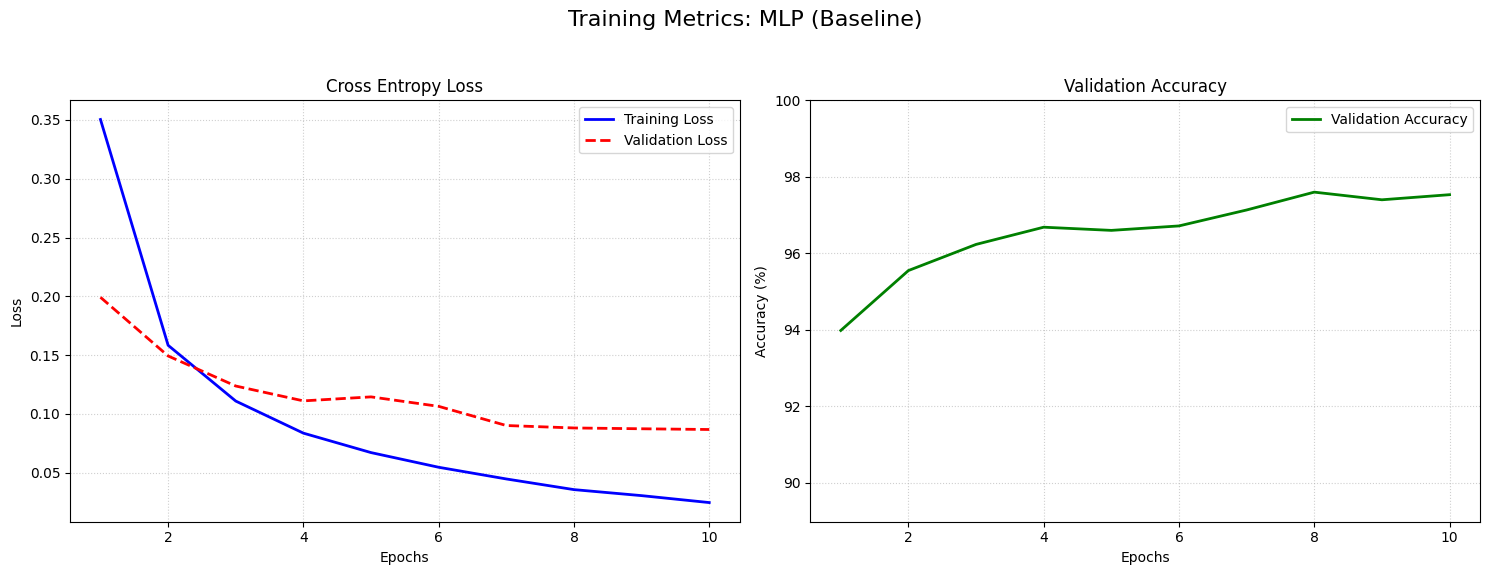

In [ ]:

# Train the MLP Baseline model and plot the results
# The number of epochs is set to 10 for the MLP baseline to provide a reasonable training duration while allowing the model to converge and achieve good accuracy on the MNIST dataset.
# This number of epochs is typically sufficient for a simple MLP architecture on MNIST, and it allows us to compare the training dynamics and final performance with the BGN model, which may require more epochs due to its 1-bit weights and increased hidden layer size.
mlp_history = run_training(mlp, 10, train_loader, val_loader, device, name="MLP (Baseline)")
plot_training_results(mlp_history, "MLP (Baseline)")


>>> Training: MLP (BGN)
Epoch 01/15 | Train Loss: 0.3946 | Val Loss: 0.2178 | Val Acc: 93.48%
Epoch 02/15 | Train Loss: 0.1922 | Val Loss: 0.1660 | Val Acc: 95.08%
Epoch 03/15 | Train Loss: 0.1438 | Val Loss: 0.1385 | Val Acc: 95.75%
Epoch 04/15 | Train Loss: 0.1184 | Val Loss: 0.1260 | Val Acc: 96.27%
Epoch 05/15 | Train Loss: 0.0969 | Val Loss: 0.1177 | Val Acc: 96.55%
Epoch 06/15 | Train Loss: 0.0820 | Val Loss: 0.1123 | Val Acc: 96.40%
Epoch 07/15 | Train Loss: 0.0705 | Val Loss: 0.1102 | Val Acc: 96.72%
Epoch 08/15 | Train Loss: 0.0649 | Val Loss: 0.1072 | Val Acc: 96.78%
Epoch 09/15 | Train Loss: 0.0571 | Val Loss: 0.1069 | Val Acc: 96.70%
Epoch 10/15 | Train Loss: 0.0529 | Val Loss: 0.1053 | Val Acc: 96.83%
Epoch 11/15 | Train Loss: 0.0471 | Val Loss: 0.1031 | Val Acc: 96.92%
Epoch 12/15 | Train Loss: 0.0434 | Val Loss: 0.1029 | Val Acc: 96.88%
Epoch 13/15 | Train Loss: 0.0420 | Val Loss: 0.1038 | Val Acc: 97.07%
Epoch 14/15 | Train Loss: 0.0367 | Val Loss: 0.1016 | Val Acc: 97

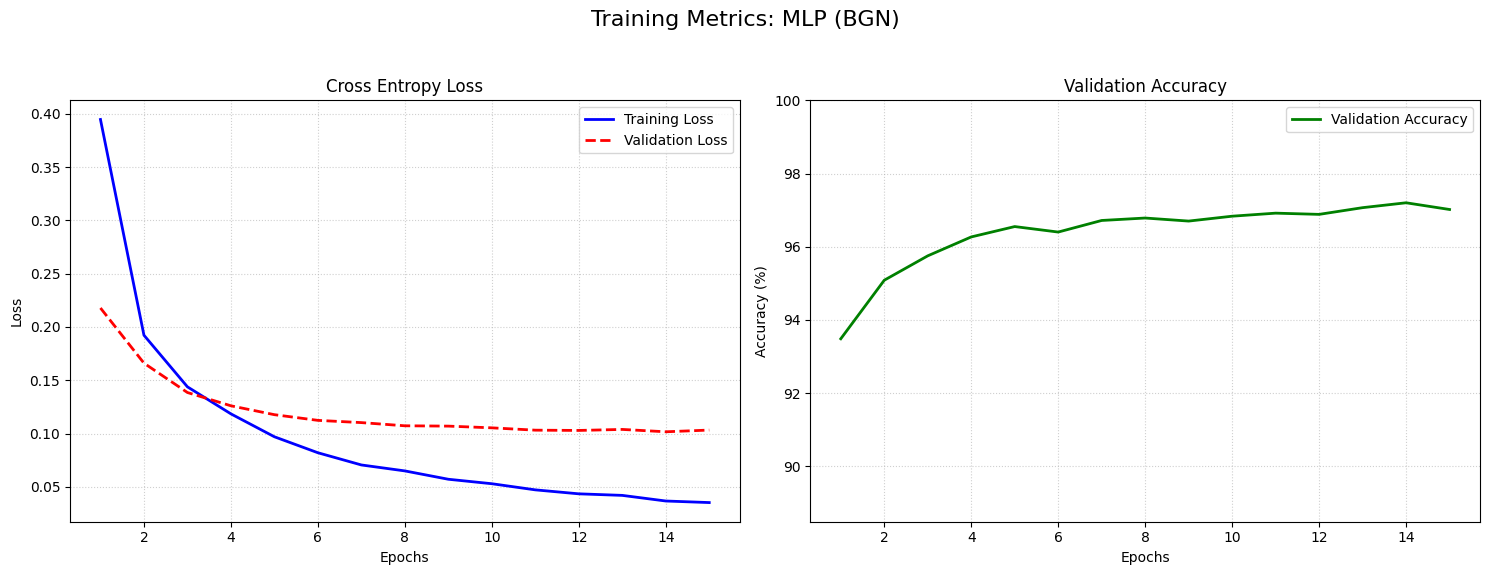

In [ ]:
# Train the BGN model and plot the results
# The learning rate is set to 0.0005 for the BGN model to help stabilize training, as BGN models with 1-bit weights can be more sensitive to higher learning rates. 
# This lower learning rate allows the model to converge more smoothly and helps mitigate the accuracy drop typically associated with training BGN models.
bgn_history = run_training(bgn, 15, train_loader, val_loader, device, name="MLP (BGN)", lr=0.0005) 
plot_training_results(bgn_history, "MLP (BGN)")

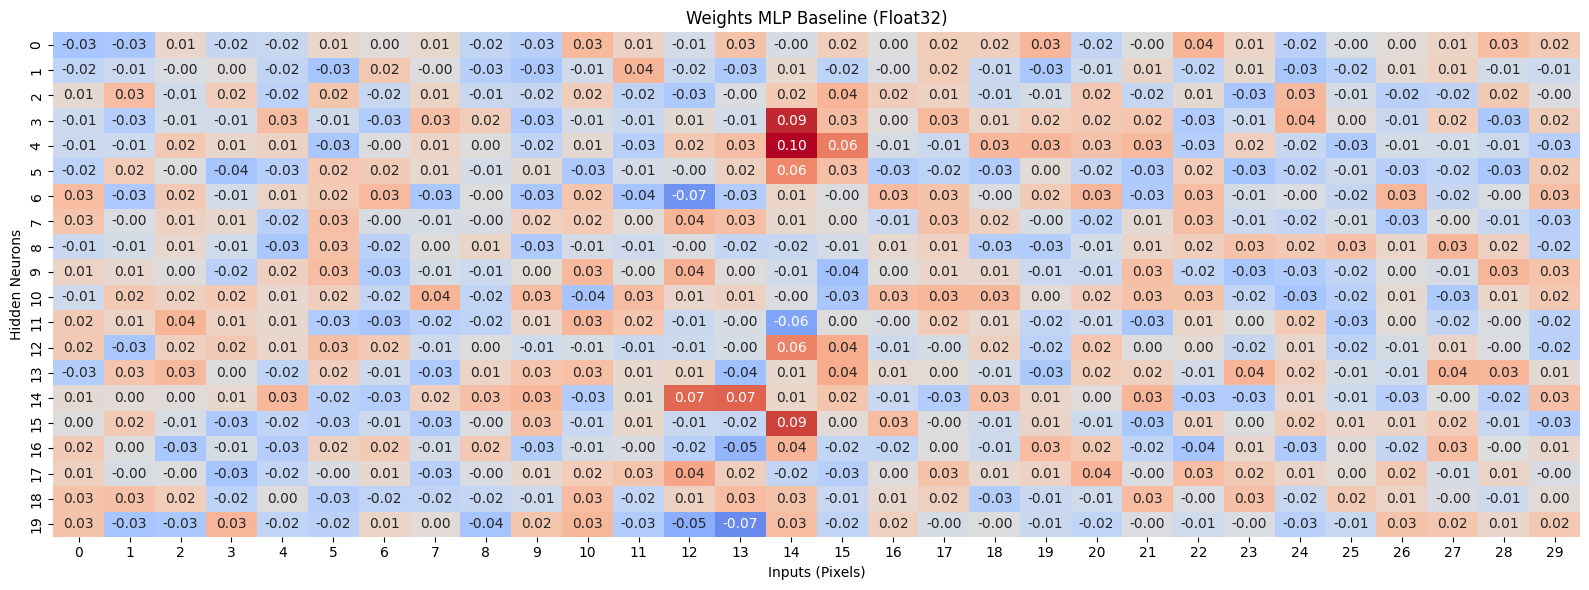

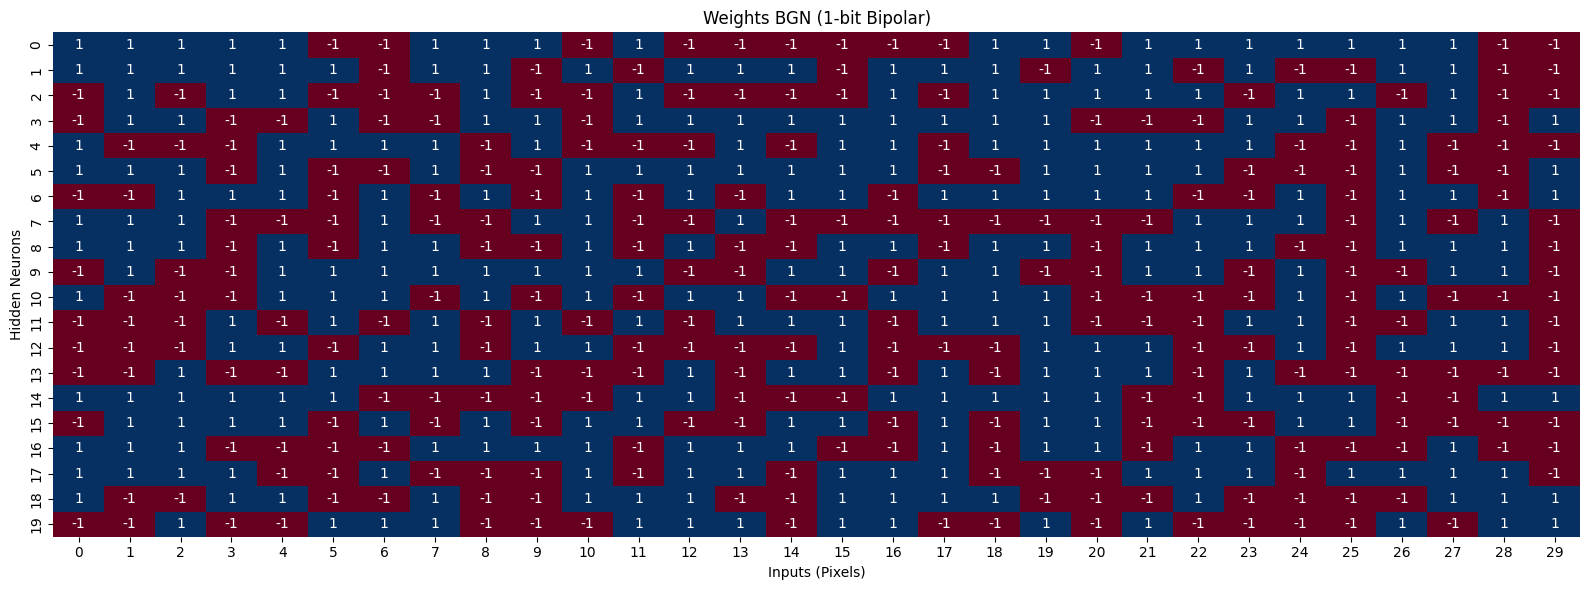

In [16]:
plot_weights_mlp(mlp, n_neurons=20, n_inputs=30)
plot_weights_bgn(bgn, n_neurons=20, n_inputs=30)

# 7. Test

In [ ]:
# Final evaluation on the test set for both models
evaluate_model(mlp, test_loader, device, name="MLP (Baseline)")
evaluate_model(bgn, test_loader, device, name="MLP (BGN)")


[FINAL EVALUATION: MLP (Baseline)]
Test Samples: 10000
Average Loss: 0.0732
Accuracy:     9769/10000 (97.69%)

[FINAL EVALUATION: MLP (BGN)]
Test Samples: 10000
Average Loss: 0.0909
Accuracy:     9739/10000 (97.39%)


97.39

# 8. Export do FPGA

In [ ]:
def export_hardware_final(model, filename="weights.h"):
    model.eval()
    with torch.no_grad():
        # 1. Binary wqeights: Convert to 0 and 1, then pack into 32-bit words
        w1_raw = (model.layer1.weights.cpu().numpy() > 0).astype(np.uint8)
        w1_packed = []
        
        # Iterate through the weight matrix and pack 32 bits into a single uint32 word
        # We process 32 bits at a time, converting them into a single hexadecimal representation for the C header file. If the last chunk has fewer than 32 bits, we pad it with zeros to ensure consistent packing.
        # This packing is crucial for efficient storage and retrieval of the binary weights on FPGA hardware, as it allows us to store 32 binary weights in a single 32-bit word, significantly reducing the memory footprint and improving access speed during inference.
        for row in range(w1_raw.shape[0]):
            # Process 32 bits at a time for each row of the weight matrix
            for i in range(0, 800, 32): 
                word = 0
                chunk = w1_raw[row, i:i+32] if i < 784 else np.zeros(32)
                for b in range(len(chunk)):
                    if b < len(chunk) and chunk[b] == 1:
                        word |= (1 << (31 - b))
                w1_packed.append(f"0x{word:08X}") # Convert the packed word to hexadecimal format for the C header file

        # 2. BatchNorm: Scale and Offset quantized to 16 bits. We calculate the scale and offset for the BatchNorm layer, which are critical for maintaining precision in the BGN model. 
        # The scale is derived from the running variance and the learned weight of the BatchNorm layer, while the offset is calculated from the learned bias and the running mean. 
        std = torch.sqrt(model.bn1.running_var + 1e-5)
        scale_bn = model.bn1.weight / std
        offset_bn = model.bn1.bias - (scale_bn * model.bn1.running_mean)
        
        # 3. Quantize the BatchNorm parameters to 16 bits by scaling them appropriately. We multiply the scale and offset by 256 (2^8) to fit them into the int16 range, then round and convert to int16. 
        # This quantization step is essential for deploying the model on FPGA hardware, as it reduces the memory footprint while still maintaining sufficient precision for the BatchNorm parameters, which are critical for the performance of the BGN model.
        bn_scale_int = np.round(scale_bn.cpu().numpy() * 256).astype(np.int16)
        bn_offset_int = np.round(offset_bn.cpu().numpy() * 256).astype(np.int16)
        
        # 4. Layer 2: Weights and Bias quantized to 8 bits. We scale the weights and biases by 64 to fit them into the int8 range, then clip the values to ensure they stay within the valid range for int8. 
        # This quantization step is essential for deploying the model on FPGA hardware, as it reduces the memory footprint and allows for efficient fixed-point arithmetic during inference.
        w2_int8 = np.clip(np.round(model.layer2.weight.cpu().numpy() * 64), -128, 127).astype(np.int8)
        b2_int8 = np.clip(np.round(model.layer2.bias.cpu().numpy() * 64), -128, 127).astype(np.int8)

    # 5. Export to C header file with 32-bit packing for binary weights and appropriate quantization for BatchNorm and Layer 2 parameters. 
    # We write the packed binary weights, quantized BatchNorm parameters, and quantized Layer 2 weights and biases to a C header file in a format that can be easily included in FPGA firmware.
    with open(filename, "w") as f:
        f.write("#ifndef WEIGHTS_H\n#define WEIGHTS_H\n#include <stdint.h>\n\n")
        
        f.write(f"const uint32_t weights_l1[{len(w1_packed)}] = {{\n")
        for i in range(0, len(w1_packed), 25):
            line = ", ".join(w1_packed[i:i+25])
            f.write(f"    {line},\n")
        f.write("};\n\n")
        
        f.write(f"const int16_t bn_scale[{bn_scale_int.size}] = {{ {','.join(map(str, bn_scale_int))} }};\n")
        f.write(f"const int16_t bn_offset[{bn_offset_int.size}] = {{ {','.join(map(str, bn_offset_int))} }};\n")
        f.write(f"const int8_t weights_l2[{w2_int8.size}] = {{ {','.join(map(str, w2_int8.flatten()))} }};\n")
        f.write(f"const int8_t bias_l2[{b2_int8.size}] = {{ {','.join(map(str, b2_int8.flatten()))} }};\n")
        f.write("\n#endif")
    print(f"File {filename} exported correctly with 32-bit packing.")

export_hardware_final(bgn)


Neurônios na camada BN: 640
Total de pesos na Layer 2: 6400
File weights.h exported correctly with 32-bit packing.


# 9. FPGA Validation

In [ ]:
# Function to load weights from the C header file and unpack them into the appropriate formats for inference.
def load_weights_final(filename="weights.h", expansion=1):
    with open(filename, 'r') as f:
        content = f.read()

    def extract(name, dtype, base=10):
        pattern = rf"{name}\s*\[.*?\]\s*=\s*\{{(.*?)\}}"
        match = re.search(pattern, content, re.DOTALL)
        if not match:
            raise ValueError(f"Variable {name} not found in the file!")
        
        # Remove comments, line breaks, and clean spaces to get a clean list of values
        clean_content = re.sub(r'//.*', '', match.group(1))
        vals = clean_content.replace('\n', '').split(',')
        
        # convert each value to the specified dtype, handling hex for weights_l1 and decimal for others
        return np.array([int(v.strip(), base) for v in vals if v.strip()], dtype=dtype)

    # 1. Extract and unpack the binary weights for Layer 1. 
    # We read the packed uint32 values from the header file, then unpack them into a binary matrix of shape (640, 784) by iterating through each packed word and extracting the individual bits.
    w1_packed = extract("weights_l1", np.uint32, base=16)
    
    # 2. Unpack the bits into the format (640, 784)
    # We need to transform each uint32 into 32 individual values {-1, 1}
    num_neurons = 128 * expansion
    w1_unpacked = []
    
    for i in range(num_neurons):
        neuron_words = w1_packed[i*25 : (i+1)*25]
        bits = []
        for word in neuron_words:
            # Extract the 32 bits respecting the order (31-b) used in the export
            for b in range(32):
                bit = (word >> (31 - b)) & 1
                bits.append(bit)
        # Cut to 784 (removing the 16-bit padding from the last word)
        w1_unpacked.append(bits[:784])
    
    # Convert to bipolar {-1, 1} as the simulator expects this format for the XNOR-Popcount equivalence.
    w1_bipolar = (np.array(w1_unpacked) * 2 - 1).astype(np.int8)

    return {
        'w1': w1_bipolar,
        'bn_s': extract("bn_scale", np.int16),
        'bn_o': extract("bn_offset", np.int16),
        'w2': extract("weights_l2", np.int8).reshape(10, 128*expansion),
        'b2': extract("bias_l2", np.int8)
    }



def fpga_inference_final(input_tensor, weights):
    # 1. Binarized Input (Simulating input_img[25] in HLS)
    # In HLS, pixels > 0.5 become bit 1. Here we convert to {-1, 1}
    # to use np.dot as the mathematical equivalent of XNOR-Popcount.

    if torch.is_tensor(input_tensor):
        x = input_tensor.detach().cpu().numpy().flatten()
    else:
        x = input_tensor.flatten()
            
    x = (x > 0.5).astype(np.int16) * 2 - 1

    # 2. Layer 1 (Equivalent to XNOR-Popcount)
    # The np.dot between {-1, 1} and weights {-1, 1} is mathematically identical to:
    # (2 * popcount(XNOR(in, w))) - num_bits
    w1 = weights['w1'] # Already in {-1, 1} format from load_weights_final
    x_layer1 = np.dot(w1.astype(np.int32), x.astype(np.int32))
    
    # 3. Batch Norm (16-bit Fixed Point)
    # Simulates exactly: (bipolar_val * scale + offset) >> 8
    bn_s = weights['bn_s'].astype(np.int32)
    bn_o = weights['bn_o'].astype(np.int32)
    x_bn = (x_layer1 * bn_s + bn_o) // 256
    
    # 4. ReLU (Ensures negative values become 0)
    x_relu = np.maximum(0, x_bn).astype(np.int16)
    
    # 5. Layer 2 (8-bit Weights)
    # Simulates exactly: (accumulator >> 6) + bias
    w2 = weights['w2'].astype(np.int32)
    b2 = weights['b2'].astype(np.int32)
    
    # High-precision accumulator before the shift
    acc_l2 = np.dot(w2, x_relu.astype(np.int32))
    output = (acc_l2 // 64) + b2
    
    return np.argmax(output), output

weights = load_weights_final("weights.h", expansion=5)


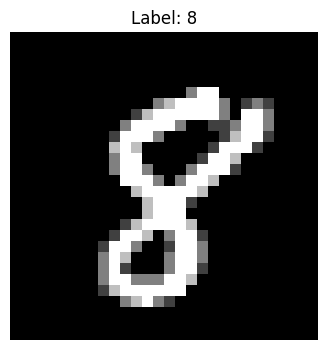

8
FPGA Simulated Prediction: 8


In [ ]:
image, label = test_dataset[random.randint(0, len(test_dataset)-1)]

show_sample(image, label)

print(label)

pred, scores = fpga_inference_final(image, weights)
print(f"FPGA Simulated Prediction: {pred}")

In [ ]:
"""
Calculates and prints a detailed hardware footprint table for the BGN model with mixed precision.
- Layer 1 (BGN): 1-bit weights
- BatchNorm: 16-bit scale and offset
- Layer 2: 8-bit weights and biases
The table includes the number of parameters, their bit-width, and the total size in KB for each layer, as well as the overall totals and the percentage of BRAM usage on a Zynq-7020 FPGA (which has 560 KB of BRAM available).
This provides a clear overview of the memory requirements for deploying the BGN model on FPGA hardware, allowing us to assess its
"""
def calculate_hardware_footprint_table(weights_dict):
    # 1. Layer 1: BGN with 1-bit weights
    # Each parameter is 1 bit, so we divide the total number of parameters by 8 to get the size in bytes, and then divide by 1024 to get KB.
    p1 = weights_dict['w1'].size
    s1 = p1 / (8 * 1024) # Size in KB (Bits / 8 / 1024)
    
    # 2. BN1: INT16 (Scale + Offset)
    # Each int16 parameter occupies 2 bytes (16 bits)
    p_bn = weights_dict['bn_s'].size + weights_dict['bn_o'].size
    s_bn = (p_bn * 2) / 1024 # Size in KB
    
    # 3. Layer 2: INT8 (Weights + Bias)
    # Each int8 parameter occupies 1 byte (8 bits)
    p2 = weights_dict['w2'].size + weights_dict['b2'].size
    s2 = p2 / 1024 # Size in KB
    
    # Totals
    total_params = p1 + p_bn + p2
    total_kb = s1 + s_bn + s2
    
    # Average Bit-width (weighted by the number of parameters in each layer to give a more accurate representation of the overall precision of the model)
    avg_bitwidth = ((p1 * 1) + (p_bn * 16) + (p2 * 8)) / total_params

    # Print the table with fixed formatting and thousand separators for better readability
    header = f"{'Layer Name':<26} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<9} | {'Size (KB)':<9}"
    sep = "-" * 84
    
    print("\n--- FINAL HARDWARE FOOTPRINT (MIXED PRECISION) ---")
    print(header)
    print(sep)
    print(f"{'layer1 (weights)':<26} | {'BGN (1-bit)':<15} | {p1:<12,} | {1.0:>9.1f} | {s1:>10.2f}")
    print(f"{'bn1 (scale/offset)':<26} | {'INT16':<15} | {p_bn:<12,} | {16.0:>8.1f} | {s_bn:>10.2f}")
    print(f"{'layer2 (weights/bias)':<26} | {'INT8':<15} | {p2:<12,} | {8.0:>9.1f} | {s2:>10.2f}")
    print(sep)
    print(f"{'TOTAL':<26} | {'':<15} | {total_params:<12,} | AVG: {avg_bitwidth:>5.1f} | {total_kb:>7.2f} KB")
    
    # Viability Metric for Zynq-7020 (560 KB of available BRAM)
    usage_pct = (total_kb / 560) * 100
    print(f"Zynq-7020 BRAM Usage: {usage_pct:.2f}%")
    print(sep + "\n")


calculate_hardware_footprint_table(weights)


--- FINAL HARDWARE FOOTPRINT (MIXED PRECISION) ---
Layer Name                 | Type            | Parameters   | Bit-width | Size (KB)
------------------------------------------------------------------------------------
layer1 (weights)           | BGN (1-bit)     | 501,760      |       1.0 |      61.25
bn1 (scale/offset)         | INT16           | 1,280        |     16.0 |       2.50
layer2 (weights/bias)      | INT8            | 6,410        |       8.0 |       6.26
------------------------------------------------------------------------------------
TOTAL                      |                 | 509,450      | AVG:   1.1 |   70.01 KB
Zynq-7020 BRAM Usage: 12.50%
------------------------------------------------------------------------------------



# 10. Test Bench

In [ ]:
# Exporting a single test image to a C header file format for FPGA inference testing. 
# The image is binarized to 1-bit (0 and 1) using a threshold of 0.5, then packed into 32-bit words for efficient storage in the C header file. 
# Each word represents 32 pixels, with bit 1 indicating a pixel value greater than 0.5 and bit 0 indicating a pixel value of 0.5 or less. 
# The output is formatted as an array of hexadecimal values that can be included in FPGA firmware for testing the inference pipeline with the BGN model.
bits = (image.flatten().numpy() > 0.5).astype(np.uint32)
packed = []

# We process 32 bits at a time, converting them into a single hexadecimal representation for the C header file. If the last chunk has fewer than 32 bits, we pad it with zeros to ensure consistent packing.
for i in range(0, 784, 32):
    word = 0
    chunk = bits[i:i+32]
    for b in range(len(chunk)):
        word |= (int(chunk[b]) << b)

    packed.append(f"0x{word:08X}") # Convert the packed word to hexadecimal format for the C header file

print(f"// Image Label: {label}")
print("ap_uint<32> test_image[25] = {" + ", ".join(packed) + "};")

// Image Label: 6
ap_uint<32> test_image[25] = {0x00000000, 0x00000000, 0x00000000, 0x000000E0, 0x7000000F, 0x03800000, 0x001C0000, 0x0000E000, 0x00000E00, 0x80000070, 0x38000003, 0x01C00000, 0x07DC0000, 0x00FEC000, 0x000DEE00, 0x0000C660, 0x40000E06, 0xE4000070, 0x0FC00003, 0x00380000, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000};


In [ ]:
"""
Enhanced function to generate a test bench image for HLS with detailed comments explaining each step of the process.
"""
def generate_hls_test_bench_image(image_tensor, label):

    # 1. Binarization: Convert the image tensor to a binary format suitable for FPGA processing.
    # Values > 0.5 become 1, the rest become 0
    binary_image = (image_tensor.flatten().numpy() > 0.5).astype(np.uint8)
    
    # 2. Padding: Ensure we have 800 bits (25 words of 32 bits)
    # 784 original pixels + 16 zero bits to complete the last word
    padded_bits = np.zeros(800, dtype=np.uint8)
    padded_bits[:784] = binary_image
    
    packed_words = []
    
    # 3. Packing into 32-bit words: We iterate through the padded binary array in chunks of 32 bits, converting each chunk into a single 32-bit word.
    for i in range(0, 800, 32):
        word = 0
        chunk = padded_bits[i:i+32]
        for b in range(len(chunk)):
            # Positioning each pixel in its corresponding bit (0 to 31)
            if chunk[b] == 1:
                # word |= (1 << b)
                word |= (1 << (31 - b))
                
        packed_words.append(f"0x{word:08X}")

    # 4. Formatted output for C++
    print(f"// --- Test Image for Label: {label} ---")
    print(f"// Binarized pixel count (1s): {np.sum(binary_image)}")
    print("ap_uint<32> test_image[25] = {")
    print("    " + ", ".join(packed_words[:5]) + ",")
    print("    " + ", ".join(packed_words[5:10]) + ",")
    print("    " + ", ".join(packed_words[10:15]) + ",")
    print("    " + ", ".join(packed_words[15:20]) + ",")
    print("    " + ", ".join(packed_words[20:25]))
    print("};")

generate_hls_test_bench_image(image, label)

// --- Test Image for Label: 6 ---
// Binarized pixel count (1s): 90
ap_uint<32> test_image[25] = {
    0x00000000, 0x00000000, 0x00000000, 0x07000000, 0xF000000E,
    0x000001C0, 0x00003800, 0x00070000, 0x00700000, 0x0E000001,
    0xC000001C, 0x00000380, 0x00003BE0, 0x00037F00, 0x0077B000,
    0x06630000, 0x60700002, 0x0E000027, 0xC00003F0, 0x00001C00,
    0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000
};
